# Türkçe Duygu Analizi Projesi

## Sentiment analysis

**Sentiment analysis** yani duygu analizi, bir metin parçasında ifade edilen duygu veya duygu durumunu belirleme görevini içeren bir doğal dil işleme (NLP) görevidir. Duygu analizinin ana hedefi, ifade edilen görüşün olumlu, olumsuz, tarafsız veya daha spesifik duyguların (mutlu, üzgün, öfkeli vb.) anlaşılmasıdır. Pazar araştırmaları, sosyal medya takibi, müşteri geri bildirimi analizi ve daha birçok alanda çeşitli uygulamalar bulunmaktadır.

Geleneksel makine öğrenimi yöntemleriyle duygu analizi yapmak için, öncelikle bir metin parçasını sayısal bir vektöre dönüştürmemiz gerekir. Bu işlem için **CountVectorizer** v**TF-IDF** ve **Word2Vec** yöntemlerini kullanacağız. Daha sonra, sayısal vektörlerimizi kullanarak bir **Multinomial Naive Bayes** sınıflandırıcısı eğiteceğiz. Eğittiğimiz sınıflandırıcıyı kullanarak, bir metin parçasının duygusunu tahmin edeceğiz.

**Bu proje, kullanıcı yorumlarının duygu analizi yapılması amacıyla iki aşamadan oluşmaktadır:**
1. Kelime Temsil Modelleri Eğitimi
2. Metin Sınıflandırma Modeli Geliştirme

### Kelime Temsil Modelleri Eğitimi

Kelime Temsil Modelleri, metin verilerini sayısal verilere dönüştürülme aşamasıdır. Bu aşamada metin verileri, sayısal verilere dönüştürülürken metin verilerinin anlamsal yapısı korunur.

Word embedding yöntemleri:
- Count Vectors
- TF-IDF Vectors
- Word2Vec
- FastText

### Kelime Temsil Modelleri Eğitimi:
1. **Veri Toplama ve Temizleme:**

    Youtube yorum verilerini toplayın ve temizleyin. Bu adımda, gereksiz karakterleri kaldırma, küçük harfe dönüştürme gibi ön işleme adımları uygulanabilir.

2. **BoW (Bag of Words) Modeli Eğitimi:**

    Veri setiniz üzerinde BoW modelini eğitin. Her belgeyi kelime sayılarına dönüştürün.

3. **TF-IDF Modeli Eğitimi:**

    Veri setiniz üzerinde TF-IDF modelini eğitin. Her belgeyi TF-IDF vektörlerine dönüştürün.

4. **Word2Vec Modeli Eğitimi:**

    Word2Vec modelini eğitmek için veri setinizi kullanın. Bu model, kelimeleri yoğun vektörlerle temsil eder.

5. **FastText Modeli Eğitimi:**
    
    FastText modelini eğitmek için veri setinizi kullanın. Bu model, kelimeleri yoğun vektörlerle temsil eder.

6. **Veri Setini Bölme:**

    Eğitim ve test veri setlerini oluşturmak için veri setinizi uygun oranlarda bölebilirsiniz.

7. **Pretrained Modellerle İyileştirme:**

    Elde ettiğiniz modelleri, önceden eğitilmiş modellerle (örneğin, medical domain odaklı modeller) birleştirerek veya fine-tuning yaparak iyileştirmeyi düşünün.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

In [3]:
# pip install gensim

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [5]:
customer_reviews = pd.read_csv("data/magaza_yorumlari_duygu_analizi.csv", sep=",", encoding="utf-16")
customer_reviews.head()

,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
1,hizli teslimat tesekkürler,Tarafsız
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz


In [6]:
# Data Cleaning
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"([-?.!,/\"])", '', text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,']", "", text)
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub('\n\n','', text)
    text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇı ]', '', text) # delete non-alphanumeric characters except Turkish characters
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = text.rstrip().strip()
    return text

In [7]:
clean_comments = []
for i in range(len(customer_reviews['Görüş'])):
    try:
        clean_comments.append(clean_text(customer_reviews['Görüş'][i]))
    except:
        clean_comments.append('None')
    if i % 1000==0:
        print(f'{i} iteration(s) completed')
customer_reviews['Clean_Comments'] = clean_comments

0 iteration(s) completed
1000 iteration(s) completed
2000 iteration(s) completed
3000 iteration(s) completed
4000 iteration(s) completed
5000 iteration(s) completed
6000 iteration(s) completed
7000 iteration(s) completed
8000 iteration(s) completed
9000 iteration(s) completed
10000 iteration(s) completed
11000 iteration(s) completed


In [8]:
customer_reviews.head()

,Görüş,Durum,Clean_Comments
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz,ses kalitesi ve ergonomisi rezalet sony olduğu...
1,hizli teslimat tesekkürler,Tarafsız,hizli teslimat tesekkürler
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu,ses olayı süpergece çalıştır sıkıntı yokkablo ...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz,kulaklığın sesi kaliteli falan değil aleti öve...


In [9]:
#Duygu Etiketlerini Sayısal Formata Dönüştürün
label_mapping = {"Olumlu": 1, "Tarafsız": 0, "Olumsuz": -1}
customer_reviews["Durum"] = customer_reviews["Durum"].map(label_mapping)

In [10]:
customer_reviews.head()

,Görüş,Durum,Clean_Comments
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",-1,ses kalitesi ve ergonomisi rezalet sony olduğu...
1,hizli teslimat tesekkürler,0,hizli teslimat tesekkürler
2,ses olayı süper....gece çalıştır sıkıntı yok.....,1,ses olayı süpergece çalıştır sıkıntı yokkablo ...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,-1,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,-1,kulaklığın sesi kaliteli falan değil aleti öve...


In [11]:
# Train ve test veri kümelerine ayır
# train_data, test_data = train_test_split(customer_reviews, test_size=0.2, random_state=42) # 80% train, 20% test

data = customer_reviews

In [12]:
print(data.shape)

(11429, 3)


In [13]:
data.head()

,Görüş,Durum,Clean_Comments
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",-1,ses kalitesi ve ergonomisi rezalet sony olduğu...
1,hizli teslimat tesekkürler,0,hizli teslimat tesekkürler
2,ses olayı süper....gece çalıştır sıkıntı yok.....,1,ses olayı süpergece çalıştır sıkıntı yokkablo ...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,-1,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,-1,kulaklığın sesi kaliteli falan değil aleti öve...


In [14]:
# BAG OF WORD
count_vectorizer = CountVectorizer(stop_words=stopwords.words('turkish'))
X_train_count = count_vectorizer.fit_transform(data['Clean_Comments'])

In [15]:
X_train_count.shape # X_train_count içerisindeki kelimelerin sayısal değerleri (vektörleri)

(11429, 38483)

In [16]:
# TF-IDF Vectors
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords.words("turkish"))
X_train_tfidf = tfidf_vectorizer.fit_transform(data['Clean_Comments'])

In [17]:
X_train_tfidf.shape # X_test içerisindeki kelimelerin TF-IDF değerleri (vektörleri)

(11429, 38483)

In [18]:
# Word2Vec
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    return tokens

# Word2Vec için tokenize edilmiş cümleleri al
tokenized_comments = [tokenize_text(comment) for comment in customer_reviews['Clean_Comments']]
tokenized_comments[:5]

[['ses',
  'kalitesi',
  've',
  'ergonomisi',
  'rezalet',
  'sony',
  'olduğu',
  'için',
  'aldım',
  'ama',
  'de',
  'fiyatına',
  'çin',
  'replika',
  'ürün',
  'alsaydım',
  'çok',
  'çok',
  'daha',
  'iyiydi',
  'kesinlikle',
  'tavsiye',
  'etmiyorum'],
 ['hizli', 'teslimat', 'tesekkürler'],
 ['ses',
  'olayı',
  'süpergece',
  'çalıştır',
  'sıkıntı',
  'yokkablo',
  'uzun',
  'işinizi',
  'çok',
  'rahat',
  'ettirirçekme',
  'olayı',
  'son',
  'derece',
  'güzel',
  'içiniz',
  'rahat',
  'olsundiğerlerini',
  'saymıyorum',
  'bile'],
 ['geldi', 'bigün', 'kullandık', 'hemen', 'bozoldu', 'hiçtavsiye', 'etmem'],
 ['kulaklığın',
  'sesi',
  'kaliteli',
  'falan',
  'değil',
  'aleti',
  'öve',
  'öve',
  'bitiremeyen',
  'yorumlar',
  'şüpheli',
  'tizler',
  'yok',
  'gibi',
  've',
  'olan',
  'da',
  'boğuk',
  'çıkıyor',
  'bas',
  'kaba',
  'saba',
  'ben',
  'buradayım',
  'diyor',
  'ama',
  'kalite',
  'yok',
  'iyi',
  'ses',
  'arayanlara',
  'tavsiye',
  'etmem',

In [19]:
# Word2Vec modelini eğit
word2vec_model = Word2Vec(sentences=tokenized_comments, vector_size=100, window=5, min_count=1, workers=4)

# Eğitilmiş Word2Vec modelini kullanarak bir kelimenin vektörünü al
word_vector = word2vec_model.wv['kelime']

# word2vec klasörü yoksa oluştur
if not os.path.exists("word2vec"):
    os.makedirs("word2vec")

# Eğitilmiş Word2Vec modelini kaydetmek isterseniz
word2vec_model.save("word2vec/word2vec_model.bin")

# Eğitilmiş Word2Vec modelini yüklemek isterseniz
loaded_word2vec_model = Word2Vec.load("word2vec/word2vec_model.bin")

In [20]:
# document_vector tokenized_comments içerisindeki tüm kelimelerin vektörlerinin ortalamasıdır
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    vectors = [word2vec_model.wv[word] for word in doc]
    return np.mean(vectors, axis=0)

# document_vector fonksiyonunu kullanarak tüm yorumların vektörlerini al
word2vec_vectors = np.zeros((len(tokenized_comments), 100))
for i in range(len(tokenized_comments)):
    word2vec_vectors[i,:] = document_vector(word2vec_model, tokenized_comments[i])

word2vec_vectors.shape

(11429, 100)

In [23]:
from gensim.models.fasttext import FastText

fasttext_model = FastText(sentences=tokenized_comments, window=5, min_count=1, workers=4)

if not os.path.exists("fasttext"):
    os.makedirs("fasttext")

# Eğitilmiş FastText modelini kaydetmek isterseniz
fasttext_model.save("fasttext/fasttext_model.bin")

# Eğitilmiş FastText modelini yüklemek isterseniz
loaded_fasttext_model = FastText.load("fasttext/fasttext_model.bin")

In [24]:
# document_vector fonksiyonunu kullanarak tüm yorumların vektörlerini al
fasttext_vectors = np.zeros((len(tokenized_comments), 100))
for i in range(len(tokenized_comments)):
    fasttext_vectors[i,:] = document_vector(fasttext_model, tokenized_comments[i])

fasttext_vectors.shape

(11429, 100)

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [28]:
# All models dictionary
from sklearn import model_selection


models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier()
}

def train_and_evaluate_models(X, y, models):
    """
    Fonksiyon, verilen modelleri eğitir ve performanslarını değerlendirir.

    Parameters:
    - X: Özelliklerin bulunduğu veri seti
    - y: Etiketlerin bulunduğu veri seti
    - models: Eğitilecek ve değerlendirilecek modellerin sözlüğü

    Returns:
    - model_accuracies: Her modelin doğruluk skoru içeren sözlük
    """

    # Veri setini eğitim ve test kümelerine ayırma
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Modelleri eğitme ve performanslarını değerlendirme
    model_accuracies = {}
    for model_name, model in models.items():
        # Modeli eğitme
        model.fit(X_train, y_train)

        # Test kümesinde performansı değerlendirme
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        # accuracy = model_selection.cross_val_score(model, X_test, y_test, cv=10).mean()

        # Sonuçları sözlüğe kaydetme
        model_accuracies[model_name] = accuracy

        # Classification Report
        # y_pred = model.predict(X_test)
        print(f"Classification Report - {model_name}")
        print(classification_report(y_test, y_pred))
        

    return model_accuracies

In [29]:
accuracy_count = train_and_evaluate_models(X_train_count, data['Durum'], models)

Classification Report - Naive Bayes
              precision    recall  f1-score   support

          -1       0.74      0.73      0.74      1254
           0       0.54      0.40      0.46       892
           1       0.73      0.88      0.80      1283

    accuracy                           0.70      3429
   macro avg       0.67      0.67      0.67      3429
weighted avg       0.69      0.70      0.69      3429

Classification Report - SVM
              precision    recall  f1-score   support

          -1       0.63      0.87      0.73      1254
           0       0.52      0.23      0.32       892
           1       0.74      0.76      0.75      1283

    accuracy                           0.66      3429
   macro avg       0.63      0.62      0.60      3429
weighted avg       0.64      0.66      0.63      3429

Classification Report - Random Forest
              precision    recall  f1-score   support

          -1       0.70      0.76      0.73      1254
           0       0.54    

In [30]:
accuracy_tfidf = train_and_evaluate_models(X_train_tfidf, data['Durum'], models)

Classification Report - Naive Bayes
              precision    recall  f1-score   support

          -1       0.67      0.87      0.75      1254
           0       0.63      0.09      0.16       892
           1       0.69      0.91      0.79      1283

    accuracy                           0.68      3429
   macro avg       0.67      0.62      0.57      3429
weighted avg       0.67      0.68      0.61      3429

Classification Report - SVM
              precision    recall  f1-score   support

          -1       0.65      0.87      0.74      1254
           0       0.56      0.29      0.39       892
           1       0.79      0.79      0.79      1283

    accuracy                           0.69      3429
   macro avg       0.67      0.65      0.64      3429
weighted avg       0.68      0.69      0.67      3429

Classification Report - Random Forest
              precision    recall  f1-score   support

          -1       0.65      0.81      0.73      1254
           0       0.59    

In [31]:
# Word2Vec
# X_train_word2vec içerisindeki tüm değerleri 0 ile 1 arasında olacak şekilde normalize ediyoruz
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_word2vec_scaled = scaler.fit_transform(word2vec_vectors)

In [32]:
accuracy_word2vec = train_and_evaluate_models(X_train_word2vec_scaled, data['Durum'], models)

Classification Report - Naive Bayes
              precision    recall  f1-score   support

          -1       0.48      0.80      0.60      1254
           0       0.00      0.00      0.00       892
           1       0.58      0.62      0.60      1283

    accuracy                           0.52      3429
   macro avg       0.36      0.47      0.40      3429
weighted avg       0.39      0.52      0.44      3429



c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Classification Report - SVM
              precision    recall  f1-score   support

          -1       0.54      0.82      0.65      1254
           0       0.54      0.16      0.25       892
           1       0.66      0.65      0.66      1283

    accuracy                           0.59      3429
   macro avg       0.58      0.54      0.52      3429
weighted avg       0.59      0.59      0.55      3429

Classification Report - Random Forest
              precision    recall  f1-score   support

          -1       0.57      0.68      0.62      1254
           0       0.46      0.32      0.38       892
           1       0.65      0.66      0.65      1283

    accuracy                           0.58      3429
   macro avg       0.56      0.55      0.55      3429
weighted avg       0.57      0.58      0.57      3429



In [33]:
X_train_fasttext_scaled = scaler.fit_transform(fasttext_vectors)
accuracy_fasttext = train_and_evaluate_models(X_train_fasttext_scaled, data['Durum'], models)

Classification Report - Naive Bayes
              precision    recall  f1-score   support

          -1       0.50      0.86      0.63      1254
           0       0.00      0.00      0.00       892
           1       0.62      0.61      0.62      1283

    accuracy                           0.54      3429
   macro avg       0.37      0.49      0.42      3429
weighted avg       0.41      0.54      0.46      3429



c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Classification Report - SVM
              precision    recall  f1-score   support

          -1       0.56      0.81      0.66      1254
           0       0.46      0.16      0.24       892
           1       0.67      0.69      0.68      1283

    accuracy                           0.60      3429
   macro avg       0.57      0.55      0.53      3429
weighted avg       0.58      0.60      0.56      3429

Classification Report - Random Forest
              precision    recall  f1-score   support

          -1       0.59      0.71      0.65      1254
           0       0.45      0.29      0.35       892
           1       0.66      0.69      0.67      1283

    accuracy                           0.59      3429
   macro avg       0.57      0.56      0.56      3429
weighted avg       0.58      0.59      0.58      3429



In [34]:
# Sonuçları değerlendirme
accuracy_df = pd.DataFrame([accuracy_count, accuracy_tfidf, accuracy_word2vec, accuracy_fasttext]).T
accuracy_df.columns = ['Count', 'TF-IDF', 'Word2Vec', 'FastText']
accuracy_df

,Count,TF-IDF,Word2Vec,FastText
Naive Bayes,0.700204,0.679790,0.523185,0.543015
SVM,0.660834,0.688831,0.585010,0.596384
Random Forest,0.657334,0.661709,0.579469,0.592884


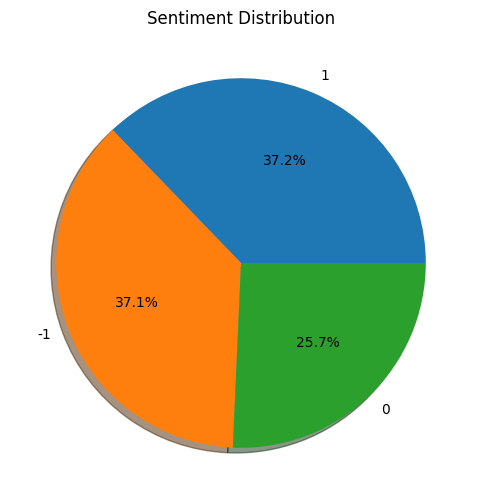

In [35]:
# Sentiment Distribution
def plot_sentiment_distribution(data):
    plt.figure(figsize=(8, 6))
    plt.pie(data.value_counts(), labels=data.value_counts().index, autopct='%1.1f%%', shadow=True)
    plt.title('Sentiment Distribution')
    plt.show()

plot_sentiment_distribution(data['Durum'])

Sonuçlar düşünüldüğünde, çok iyi bir performans elde edemedik. Veri setindeki yorumların çoğu olumlu/olumsuz olduğu için, modelimiz tarafsız yorumları tahmin etmekte zorlanıyor olabilir.

In [36]:
data.head()

,Görüş,Durum,Clean_Comments
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",-1,ses kalitesi ve ergonomisi rezalet sony olduğu...
1,hizli teslimat tesekkürler,0,hizli teslimat tesekkürler
2,ses olayı süper....gece çalıştır sıkıntı yok.....,1,ses olayı süpergece çalıştır sıkıntı yokkablo ...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,-1,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,-1,kulaklığın sesi kaliteli falan değil aleti öve...


In [37]:
# Naive Bayes, en yüksek doğruluk skoruna sahip modeldir. Youtube yorumları için en iyi modeldir. youtube_comeents.csv dosyasındaki etiketlenmemiş değerleri tahmin etmek için kullanılabilir. 
# Bu modeli tekrar eğitmek isterseniz, aşağıdaki kodu çalıştırın.

# BagOfWord Naive Bayes
# BAG OF WORD
count_vectorizer = CountVectorizer(stop_words=stopwords.words('turkish'))
X_train_count = count_vectorizer.fit_transform(data['Clean_Comments'])

# Train ve test veri kümelerindeki kelimelerin vektörlerini al
X_train_count = count_vectorizer.fit_transform(data['Clean_Comments'])

# Veri setini eğitim ve test kümelerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_train_count, data['Durum'], test_size=0.3, random_state=42)

# Modeli eğitme
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)

# Test kümesinde performansı değerlendirme
y_pred = model_NB.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report")
print(classification_report(y_test, y_pred))

Accuracy: 0.7002041411490231
Classification Report
              precision    recall  f1-score   support

          -1       0.74      0.73      0.74      1254
           0       0.54      0.40      0.46       892
           1       0.73      0.88      0.80      1283

    accuracy                           0.70      3429
   macro avg       0.67      0.67      0.67      3429
weighted avg       0.69      0.70      0.69      3429



In [38]:
if not os.path.exists("model_NB"):
    os.makedirs("model_NB")

# Modeli kaydetmek için pickle kütüphanesini kullanıyoruz.
import pickle
with open('model_NB/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(model_NB, f)

## Sentiment Analysis with TextBlob

![title](ddi_yontemleri.png)

![title](ddi_yontemleri2.png)

In [39]:
# from api_methods import *
from api_methods import get_chanel_stats, get_video_comments

from googleapiclient.discovery import build
from IPython.display import JSON
from config.config import YOUTUBE_API_KEY

In [40]:
# pip install textblob
# pip install wordcloud

In [41]:
# Get credentials and create an API client
api_service_name = "youtube"
api_version = "v3"

youtube = build(
    api_service_name, api_version, developerKey=YOUTUBE_API_KEY)

In [42]:
# Channels to analyze
channel_ids = [
    "UCv6jcPwFujuTIwFQ11jt1Yw", # BarisOzcan
    "UCZhjDQKnEM_oxZUK2X2MiwA", # SabanciVakfi
    "UCDLlvoriOfvbfUL3P1SyGkg", # sisterslab
    "UCatnasFAiXUvWwH8NlSdd3A", # evrimagaci
    # Can add more channels
]

In [44]:
channel_stats = get_chanel_stats(youtube, channel_ids)

In [45]:
channel_stats_df = pd.DataFrame(channel_stats)
channel_stats_df.head()

,channel_id,channelName,subscribers,views,totalVideos,playlistId
0,UCZhjDQKnEM_oxZUK2X2MiwA,Sabancı Vakfı,29400,51103463,1050,UUZhjDQKnEM_oxZUK2X2MiwA
1,UCatnasFAiXUvWwH8NlSdd3A,Evrim Ağacı,3430000,1226899781,1260,UUatnasFAiXUvWwH8NlSdd3A
2,UCDLlvoriOfvbfUL3P1SyGkg,SistersLab | Bilim ve Teknolojide Kadın Derneği,927,20032,79,UUDLlvoriOfvbfUL3P1SyGkg
3,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,6500000,846900892,777,UUv6jcPwFujuTIwFQ11jt1Yw


In [46]:
video_ids = [
    "7DFs2WifolI", # BarisOzcan - 1
    "v7EQfnFosHE", # BarisOzcan - 2
    "d9xJc2Dc_1s", # BarisOzcan - 3
    "jS9tx2oU9E8", # SabanciVakfi - 1
    "ZrP_2DPXFiA", # SabanciVakfi - 2
    "oKrdWwoNzak", # sisterslab - 1
    "46w7r4vKPhU", # evrimagaci - 1
    "XSqkDCSpZjM", # evrimagaci - 2
]

In [47]:
# Get video comments
video_comments = get_video_comments(youtube, video_ids)
# video_comments to dataframe
video_comments_df = pd.DataFrame(video_comments)
video_comments_df.head()

,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID
0,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Zaman Makinası gibi,Ugxj5UfC_MdXlykcL2Z4AaABAg,0,0,2024-01-19 22:35:20,UCQxj0TvV3SSfQbzik50sT4Q
1,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,MERHABA AZ ÖNCE ETKİNLİĞE YAZAMADIĞIM İÇİN YAZ...,Ugy82Yb1XT3A4d2z8EN4AaABAg,0,0,2024-01-17 19:19:00,UC2ZLRP_biaJvHGI9qAjqlGA
2,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,En sevdiğim dizi ❤,UgyMk8zSvNuGpbMD4aB4AaABAg,0,0,2024-01-17 11:46:12,UCzze-I6SRUpOgXVR3LWAoaQ
3,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Arka sokakları da geçmiş tebrikler🎉🎉🎉,UgzXZyinLiVRfAgsTA54AaABAg,0,0,2024-01-16 20:34:29,UCPHH_k7ritjJRGkTOUc6MaA
4,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,en sevdiğim bilim kurgu dizisi ve en korktuğum...,UgxijlBIcA82fSOOjdp4AaABAg,0,0,2024-01-16 20:32:00,UCjbRO-1Urf2GpMELSAVduhQ


In [48]:
# Check the number of comments
len(video_comments_df)

3889

In [49]:
video_comments_df.reset_index(drop=True)
video_comments_df.head()

,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID
0,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Zaman Makinası gibi,Ugxj5UfC_MdXlykcL2Z4AaABAg,0,0,2024-01-19 22:35:20,UCQxj0TvV3SSfQbzik50sT4Q
1,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,MERHABA AZ ÖNCE ETKİNLİĞE YAZAMADIĞIM İÇİN YAZ...,Ugy82Yb1XT3A4d2z8EN4AaABAg,0,0,2024-01-17 19:19:00,UC2ZLRP_biaJvHGI9qAjqlGA
2,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,En sevdiğim dizi ❤,UgyMk8zSvNuGpbMD4aB4AaABAg,0,0,2024-01-17 11:46:12,UCzze-I6SRUpOgXVR3LWAoaQ
3,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Arka sokakları da geçmiş tebrikler🎉🎉🎉,UgzXZyinLiVRfAgsTA54AaABAg,0,0,2024-01-16 20:34:29,UCPHH_k7ritjJRGkTOUc6MaA
4,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,en sevdiğim bilim kurgu dizisi ve en korktuğum...,UgxijlBIcA82fSOOjdp4AaABAg,0,0,2024-01-16 20:32:00,UCjbRO-1Urf2GpMELSAVduhQ


In [50]:
# Save to csv
video_comments_df.to_csv("data/youtube_comments.csv")

## Read from CSV

In [51]:
# Read from csv
youtube_comments = pd.read_csv("data/youtube_comments.csv")
youtube_comments.drop(columns=["Unnamed: 0"], inplace=True)

In [52]:
youtube_comments.sample(5)

,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID
3524,XSqkDCSpZjM,"UFO'lar, Uzaylıları Kanıtlıyor mu?","2017 yılında, kırmızımsı, kayalık ve ilginç bi...",2024-01-11 15:31:50,UCatnasFAiXUvWwH8NlSdd3A,Evrim Ağacı,1111,421662,19724,934,❤❤😊,UgxWO8drJAo9758Vo5V4AaABAg,0,0,2024-01-11 22:50:59,UCTCwv_HBd4gWGtYpHAs7x_A
790,v7EQfnFosHE,Ax-3 Uzay Görevi: Bizim için anlamı büyük bir ...,Uzaya gitmek nasıl bir şeydir acaba? Hiç düşün...,2024-01-16 04:00:21,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,627,459279,24129,1538,baris bey bu yolculugun parayla satin alindigi...,Ugzd-jDV-Rfjdg34NP14AaABAg,2,0,2024-01-18 12:26:15,UCZdeF3HhPVs83IS_FG3g0kA
889,v7EQfnFosHE,Ax-3 Uzay Görevi: Bizim için anlamı büyük bir ...,Uzaya gitmek nasıl bir şeydir acaba? Hiç düşün...,2024-01-16 04:00:21,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,627,459279,24129,1538,Zathura filmine hayran kalmıştım küçükken.,UgwybbUJvM3HwoujLGl4AaABAg,0,0,2024-01-17 15:33:53,UCrZsBBznn_NyiSVqKQ8ZKqg
461,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Doctor Who favori dizimdir.,UgwsaMPctPkzb7FH3LJ4AaABAg,0,0,2023-11-23 06:26:12,UC2XzTIuJnoIZlkGqZbZB7vA
879,v7EQfnFosHE,Ax-3 Uzay Görevi: Bizim için anlamı büyük bir ...,Uzaya gitmek nasıl bir şeydir acaba? Hiç düşün...,2024-01-16 04:00:21,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,627,459279,24129,1538,Silifkeliler burdamı as bayrakları,Ugz5jqPcSA508wopaop4AaABAg,0,0,2024-01-17 16:57:26,UCXkBK40xU3DxIvgeg5rbcMQ


In [53]:
# Count the number of videos and comments received per channel
youtube_comments.groupby("channelName").agg({"Video_ID": "nunique", "Comments": "count"})

,Video_ID,Comments
channelName,,
Barış Özcan,3,2604
Evrim Ağacı,2,1158
Sabancı Vakfı,2,126
SistersLab | Bilim ve Teknolojide Kadın Derneği,1,1


In [54]:
# Video_Views for each channel
youtube_comments.groupby("channelName").agg({"Video_Views": "sum"})

,Video_Views
channelName,
Barış Özcan,1174119409
Evrim Ağacı,550290174
Sabancı Vakfı,508681677
SistersLab | Bilim ve Teknolojide Kadın Derneği,277


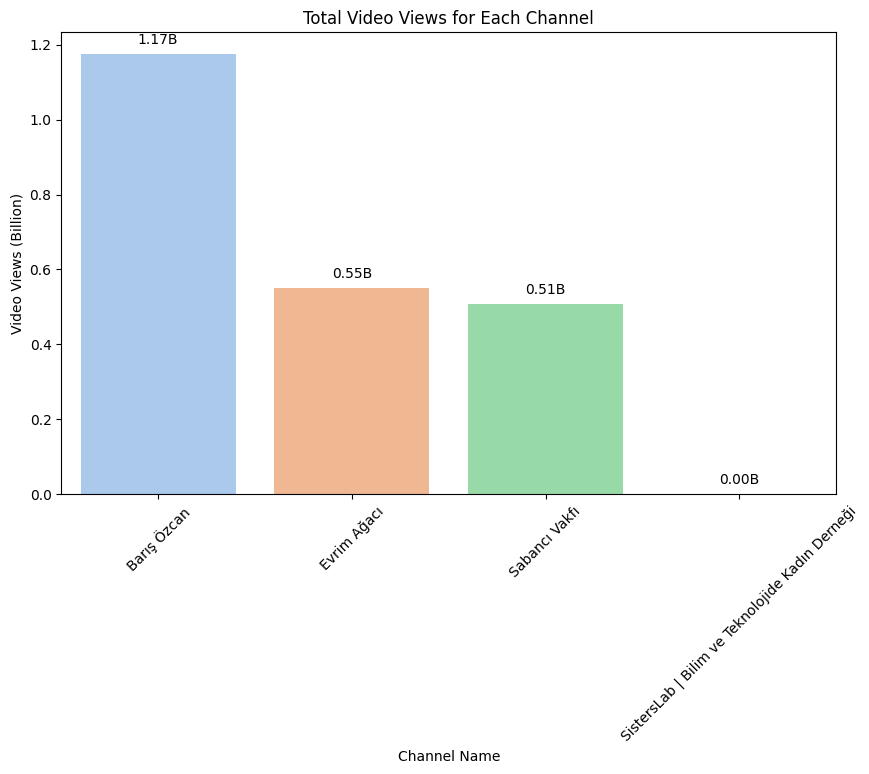

In [55]:
# Show Video_Views for each channel
views = youtube_comments.groupby("channelName").agg({"Video_Views": "sum"})
views_billion = views / 1e9

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=views_billion.index, y="Video_Views", hue=views_billion.index, data=views_billion, palette="pastel")
# ax = sns.barplot(y="Video_Views", hue=views_billion.index, data=views_billion, palette="pastel")

# Annotate each bar with its actual value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}B', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45)
plt.xlabel("Channel Name")
plt.ylabel("Video Views (Billion)")
plt.title("Total Video Views for Each Channel")
plt.show()

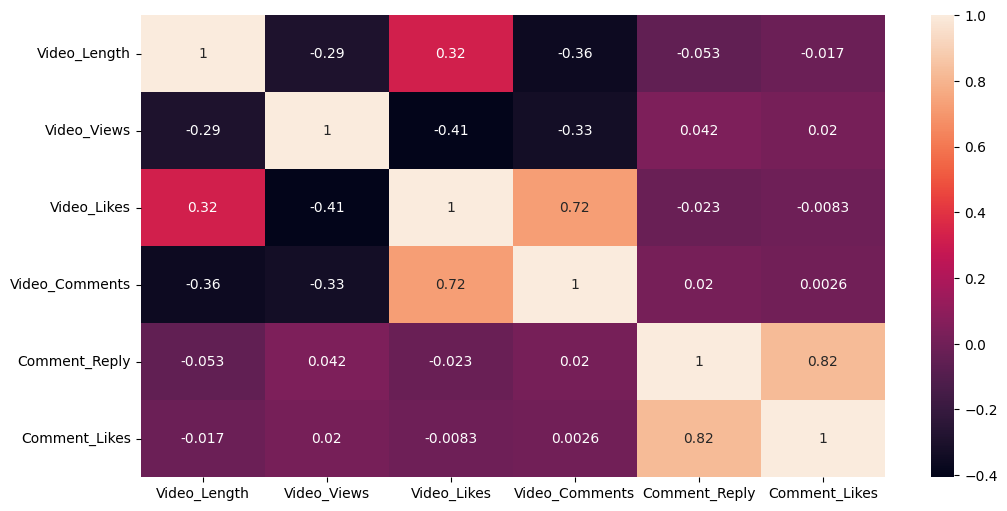

In [56]:
corr = youtube_comments[['Video_Length', 'Video_Views', 'Video_Likes', 'Video_Comments', 'Comment_Reply', 'Comment_Likes']].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True)
plt.show()

- Video_Likes ve Video_Comments arasında pozitif bir ilişki var.
- Comment_Likes ve Comment_Reply arasında pozitif bir ilişki var.

In [57]:
# Find the video with the highest number of views
# max_views_video = youtube_comments.loc[youtube_comments['Video_Views'].idxmax()]

# Each channel's most viewed video
youtube_comments.loc[youtube_comments.groupby('channelName')['Video_Views'].idxmax()]

,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID
1625,d9xJc2Dc_1s,Yaşayan en ilginç matematikçiye ne oldu?,“Bugüne kadar yaşamış en büyük matematikçi kim...,2024-01-07 06:00:15,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,1192,556746,27528,1116,"&quot;Barış Bey, hak ettiğiniz yerin çok geris...",UgypwW6TzFiTUFxZQ5N4AaABAg,0,0,2024-01-24 05:45:29,UCk4RkwOgAlAy1H-KJu3Cx5w
2731,46w7r4vKPhU,"NASA, 14 Astronotu Nasıl Öldürdü?","28 Ocak 1986... O yıllar, NASA'nın tam anlamıy...",2024-01-18 15:29:47,UCatnasFAiXUvWwH8NlSdd3A,Evrim Ağacı,1631,567215,19374,526,"⛱ İş ortaklarımızla tanışın, hem siz kazanın h...",UgylzV8Yl77_7j6l_y54AaABAg,2,65,2024-01-18 07:31:50,UCatnasFAiXUvWwH8NlSdd3A
2604,jS9tx2oU9E8,"Bir Kız Çocuğu Değişir, Dünya Değişir | 11 Eki...",Sivas’ın Kolluca Köyü’nden bir kız çocuğu dokt...,2022-10-10 09:10:29,UCZhjDQKnEM_oxZUK2X2MiwA,Sabancı Vakfı,164,4833745,2960,190,Kızlara ya da kadınlara daha fazla olanak veri...,Ugw43FZ2xqAnU_vCJKB4AaABAg,0,0,2024-01-10 01:00:18,UCXxnq9tfdc4DOIGIwFOcg5A
2730,oKrdWwoNzak,Mesleğini Tanı(t) Canlı Yayın Serisi #18 | İlk...,📢 Mesleğini Tanı(t) canlı yayın serimiz devam ...,2021-08-12 05:45:10,UCDLlvoriOfvbfUL3P1SyGkg,SistersLab | Bilim ve Teknolojide Kadın Derneği,2415,277,22,1,Çok enerjik bir insan faydalı bir konuşma olmuş,UgxS9aBTopxJB8-t_CF4AaABAg,0,2,2021-08-17 21:47:35,UC0VaaEtpauwoGA1PZg4WYkQ


In [58]:
# show each channel's most liked video and its number of likes
number_of_likes = youtube_comments.loc[youtube_comments.groupby('channelName')['Video_Likes'].idxmax()][['Video_Title', 'Video_Likes']]
number_of_likes

,Video_Title,Video_Likes
1625,Yaşayan en ilginç matematikçiye ne oldu?,27528
3157,"UFO'lar, Uzaylıları Kanıtlıyor mu?",19724
2604,"Bir Kız Çocuğu Değişir, Dünya Değişir | 11 Eki...",2960
2730,Mesleğini Tanı(t) Canlı Yayın Serisi #18 | İlk...,22


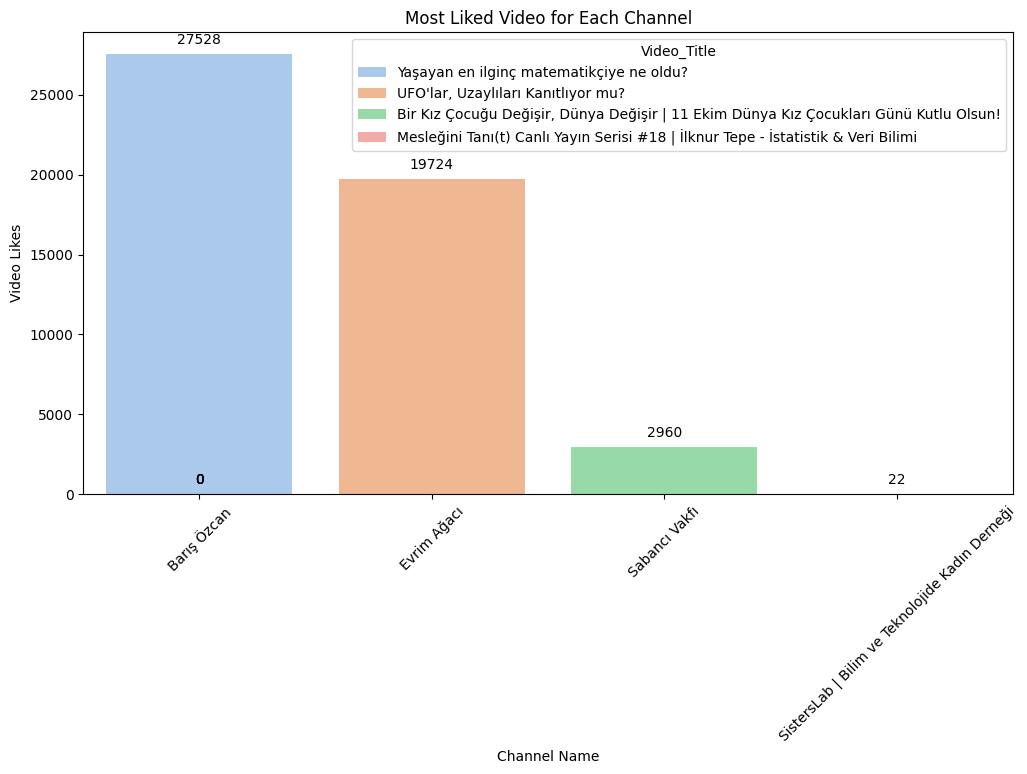

In [59]:
# Find each channel's most liked video and its number of likes
number_of_likes = youtube_comments.loc[youtube_comments.groupby('channelName')['Video_Likes'].idxmax()][['channelName', 'Video_Title', 'Video_Likes']]

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='channelName' , y='Video_Likes', hue='Video_Title', data=number_of_likes, palette="pastel")

# Annotate each bar with its actual value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45)
plt.xlabel("Channel Name")
plt.ylabel("Video Likes")
plt.title("Most Liked Video for Each Channel")
plt.show()


## Sentiment analysis

**Sentiment analysis** yani duygu analizi, bir metin parçasında ifade edilen duygu veya duygu durumunu belirleme görevini içeren bir doğal dil işleme (NLP) görevidir. Duygu analizinin ana hedefi, ifade edilen görüşün olumlu, olumsuz, tarafsız veya daha spesifik duyguların (mutlu, üzgün, öfkeli vb.) anlaşılmasıdır. Pazar araştırmaları, sosyal medya takibi, müşteri geri bildirimi analizi ve daha birçok alanda çeşitli uygulamalar bulunmaktadır. 

Geleneksel duygu analizi yaklaşımları genellikle el yapımı özelliklere ve Destek Vektör Makineleri (SVM), Naive Bayes veya lojistik regresyon gibi makine öğrenimi algoritmalarına dayanıyordu. Bu modeller, alan özel özellik mühendisliği gerektiriyordu ve karmaşık dil kalıplarını etkili bir şekilde yakalama yeteneğinden yoksundur. 

Bert ve GPT-3 gibi yeni nesil dil modelleri, bu sorunları çözmek için tasarlanmıştır. Bu modeller, özellik çıkarımı ve özellik mühendisliği gerektirmez ve dil kalıplarını daha iyi yakalayabilir.

In [60]:
print('Comments on videos - ', format(len(youtube_comments['Comments'])))
print('Unique Videos - ', format(youtube_comments['Video_ID'].nunique()))
print('Average comments per video -', format(int(len(youtube_comments['Comments'])/youtube_comments['Video_ID'].nunique())))

Comments on videos -  3889
Unique Videos -  8
Average comments per video - 486


In [61]:
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r"([-?.!,/\"])", '', text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,']", "", text)
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub('\n\n','', text)
    text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇı ]', '', text) # delete non-alphanumeric characters except Turkish characters
    text = text.rstrip().strip()
    return text

In [62]:
clean_text(youtube_comments['Comments'][0])

'zaman makinası gibi'

In [63]:
clean_comments = []
for i in range(len(youtube_comments['Comments'])):
    try:
        clean_comments.append(clean_text(youtube_comments['Comments'][i]))
    except:
        clean_comments.append('None')
    if i % 1000==0:
        print(f'{i} iteration(s) completed')
youtube_comments['Clean Comments'] = clean_comments

0 iteration(s) completed
1000 iteration(s) completed
2000 iteration(s) completed
3000 iteration(s) completed


In [64]:
youtube_comments.sample(5)

,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID,Clean Comments
3290,XSqkDCSpZjM,"UFO'lar, Uzaylıları Kanıtlıyor mu?","2017 yılında, kırmızımsı, kayalık ve ilginç bi...",2024-01-11 15:31:50,UCatnasFAiXUvWwH8NlSdd3A,Evrim Ağacı,1111,421662,19724,934,"Arkadaşımızın biri bir astronomun söylemini, ...",UgwKip6Nh3V9zPuaL6V4AaABAg,0,0,2024-01-14 11:04:48,UCs8VZVTvCxOfoPtW26JopAw,arkadaşımızın biri bir astronomun söylemini bi...
622,v7EQfnFosHE,Ax-3 Uzay Görevi: Bizim için anlamı büyük bir ...,Uzaya gitmek nasıl bir şeydir acaba? Hiç düşün...,2024-01-16 04:00:21,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,627,459279,24129,1538,Abi sen geldin dünyaya çıktık diye bize senary...,UgynirR9qv7wY2Cd0754AaABAg,0,0,2024-01-20 07:16:29,UCU9PM1DIA73hT-0oq3hLkIA,abi sen geldin dünyaya çıktık diye bize senary...
2380,d9xJc2Dc_1s,Yaşayan en ilginç matematikçiye ne oldu?,“Bugüne kadar yaşamış en büyük matematikçi kim...,2024-01-07 06:00:15,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,1192,556746,27528,1116,Başta ödülü niye almadı diye düşünüyorken sond...,UgwcsO8tDpC6_13PeEt4AaABAg,0,0,2024-01-07 09:05:33,UCXfEiAKKqoAlOL3G5KQe5TQ,başta ödülü niye almadı diye düşünüyorken sond...
1302,v7EQfnFosHE,Ax-3 Uzay Görevi: Bizim için anlamı büyük bir ...,Uzaya gitmek nasıl bir şeydir acaba? Hiç düşün...,2024-01-16 04:00:21,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,627,459279,24129,1538,🇹🇷🇹🇷🇹🇷💯💯👏👏,UgwZL7DXmobnHWqWBm14AaABAg,0,0,2024-01-16 09:35:39,UCvVqaCZbMkjpaE5lzA3tCKw,
1670,d9xJc2Dc_1s,Yaşayan en ilginç matematikçiye ne oldu?,“Bugüne kadar yaşamış en büyük matematikçi kim...,2024-01-07 06:00:15,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,1192,556746,27528,1116,Benim ilgimi ceken sey adamin yine Yahudi olma...,Ugx4VraI4kvrKsbPcnp4AaABAg,0,0,2024-01-16 23:50:29,UCSsZ-TSIFV5iFXEconAFbdw,benim ilgimi ceken sey adamin yine yahudi olma...


### Gerçek veri setimizdeki yorumların duygusal analizini hangi model ve verisetleri ile eğitebiliriz?

Naive Bayes, en yüksek doğruluk skoruna sahip modeldir. youtube_comeents.csv dosyasındaki etiketlenmemiş yorumların duygu analizlerini tahmin etmek için kullanılabilir.

In [65]:
# Clean Comments için loaded_model kullanarak duygu analizi yapabilirsiniz.
# Bu modeli tekrar eğitmek isterseniz, aşağıdaki kodu çalıştırın.
# Modeli yüklemek için pickle kütüphanesini kullanıyoruz.
# with open('model_NB/naive_bayes_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

In [66]:
# # Yeni test kümemiz Clean Comments olsun.
# X_test_count = count_vectorizer.transform(youtube_comments['Clean Comments'])
# # Test kümesinde performansı değerlendirme
# y_pred = loaded_model.predict(X_test_count)
# youtube_comments['Predicted Sentiment'] = y_pred
# youtube_comments.head()

Gerçek veri setimizdeki yorumların duygusal analizini geleneksel yöntemlerle yapmak pek iyi sonuçlar vermedi.

Bu nedenle, TextBlob modelini kullanarak duygusal analiz yapacağız.

Polarity is a float value within the range [-1.0 to 1.0].

- Here, 0 indicates neutral,

- +1 indicates a very positive sentiment, and

- -1 represents a very negative sentiment.

In [67]:
# 1. Sentiment Analysis with TextBlob
polarity = []
for i in youtube_comments['Clean Comments']:
    blob = TextBlob(i)
    polarity.append(round(blob.sentiment.polarity,3))
youtube_comments['polarity'] = polarity
print('Polarity Column added to the dataframe')
youtube_comments.head()

Polarity Column added to the dataframe


,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID,Clean Comments,polarity
0,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Zaman Makinası gibi,Ugxj5UfC_MdXlykcL2Z4AaABAg,0,0,2024-01-19 22:35:20,UCQxj0TvV3SSfQbzik50sT4Q,zaman makinası gibi,0.0
1,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,MERHABA AZ ÖNCE ETKİNLİĞE YAZAMADIĞIM İÇİN YAZ...,Ugy82Yb1XT3A4d2z8EN4AaABAg,0,0,2024-01-17 19:19:00,UC2ZLRP_biaJvHGI9qAjqlGA,merhaba az önce etkinliğe yazamadiğim için yaz...,0.0
2,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,En sevdiğim dizi ❤,UgyMk8zSvNuGpbMD4aB4AaABAg,0,0,2024-01-17 11:46:12,UCzze-I6SRUpOgXVR3LWAoaQ,en sevdiğim dizi,0.0
3,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Arka sokakları da geçmiş tebrikler🎉🎉🎉,UgzXZyinLiVRfAgsTA54AaABAg,0,0,2024-01-16 20:34:29,UCPHH_k7ritjJRGkTOUc6MaA,arka sokakları da geçmiş tebrikler,0.0
4,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,en sevdiğim bilim kurgu dizisi ve en korktuğum...,UgxijlBIcA82fSOOjdp4AaABAg,0,0,2024-01-16 20:32:00,UCjbRO-1Urf2GpMELSAVduhQ,en sevdiğim bilim kurgu dizisi ve en korktuğum...,0.0


In [68]:
print('Reviews with Positive Sentiment based on Polarity :', len(youtube_comments[youtube_comments['polarity'] > 0]))
print('Reviews with Negative Sentiment based on Polarity :', len(youtube_comments[youtube_comments['polarity'] < 0]))
print('Reviews with Neutral Sentiment based on Polarity :', len(youtube_comments[youtube_comments['polarity'] == 0]))

Reviews with Positive Sentiment based on Polarity : 64
Reviews with Negative Sentiment based on Polarity : 13
Reviews with Neutral Sentiment based on Polarity : 3812


In [69]:
sentiment = []
for i in youtube_comments['polarity']:
    if i > 0:
        sentiment.append(1)
    elif i < 0:
        sentiment.append(-1)
    else:
        sentiment.append(0)
youtube_comments['Sentiment'] = sentiment
youtube_comments.head()

,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID,Clean Comments,polarity,Sentiment
0,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Zaman Makinası gibi,Ugxj5UfC_MdXlykcL2Z4AaABAg,0,0,2024-01-19 22:35:20,UCQxj0TvV3SSfQbzik50sT4Q,zaman makinası gibi,0.0,0
1,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,MERHABA AZ ÖNCE ETKİNLİĞE YAZAMADIĞIM İÇİN YAZ...,Ugy82Yb1XT3A4d2z8EN4AaABAg,0,0,2024-01-17 19:19:00,UC2ZLRP_biaJvHGI9qAjqlGA,merhaba az önce etkinliğe yazamadiğim için yaz...,0.0,0
2,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,En sevdiğim dizi ❤,UgyMk8zSvNuGpbMD4aB4AaABAg,0,0,2024-01-17 11:46:12,UCzze-I6SRUpOgXVR3LWAoaQ,en sevdiğim dizi,0.0,0
3,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Arka sokakları da geçmiş tebrikler🎉🎉🎉,UgzXZyinLiVRfAgsTA54AaABAg,0,0,2024-01-16 20:34:29,UCPHH_k7ritjJRGkTOUc6MaA,arka sokakları da geçmiş tebrikler,0.0,0
4,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,en sevdiğim bilim kurgu dizisi ve en korktuğum...,UgxijlBIcA82fSOOjdp4AaABAg,0,0,2024-01-16 20:32:00,UCjbRO-1Urf2GpMELSAVduhQ,en sevdiğim bilim kurgu dizisi ve en korktuğum...,0.0,0


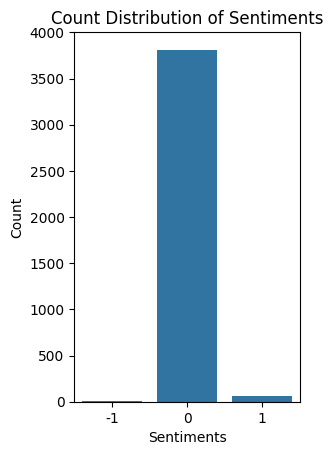

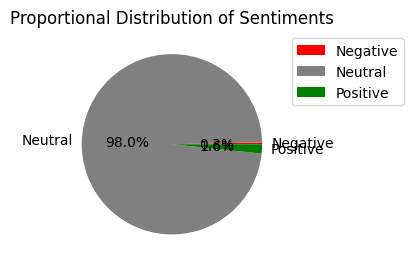

In [76]:
# Plotting the Count and Proportional Distribution of reviews based on sentiment as per polarity
plt.subplot(1, 2, 1)

# Plotting the count of reviews for each sentiment
sns.countplot(x='Sentiment', data=youtube_comments)
plt.title('Count Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.show()

plt.subplot(1, 2, 2)
# Plotting the proportional distribution of sentiments
# Colors for each segment
colors = ['red', 'gray', 'green']

plt.pie(x=[len(youtube_comments[youtube_comments['polarity'] < 0]), len(youtube_comments[youtube_comments['polarity'] == 0]),
           len(youtube_comments[youtube_comments['polarity'] > 0])],
        labels=['Negative', 'Neutral', 'Positive'],
        autopct='%1.1f%%', pctdistance=0.5, colors=colors,
        textprops={'fontsize':10})
plt.title('Proportional Distribution of Sentiments')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [77]:
# Makine öğrenmesi modelleri ile duygu analizi yapmak için
with open('model_NB/naive_bayes_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Yeni test kümemiz Clean Comments olsun.
X_test_count = count_vectorizer.transform(youtube_comments['Clean Comments'])
# Test kümesinin accuracy değerini görelim
y_pred = loaded_model.predict(X_test_count)
youtube_comments['Predicted_Sentiment'] = y_pred
youtube_comments.head()

,Video_ID,Video_Title,Video_Description,Video_Published_Date,channel_id,channelName,Video_Length,Video_Views,Video_Likes,Video_Comments,Comments,Comment_ID,Comment_Reply,Comment_Likes,Comment_Date,User_ID,Clean Comments,polarity,Sentiment,Predicted_Sentiment
0,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Zaman Makinası gibi,Ugxj5UfC_MdXlykcL2Z4AaABAg,0,0,2024-01-19 22:35:20,UCQxj0TvV3SSfQbzik50sT4Q,zaman makinası gibi,0.0,0,-1
1,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,MERHABA AZ ÖNCE ETKİNLİĞE YAZAMADIĞIM İÇİN YAZ...,Ugy82Yb1XT3A4d2z8EN4AaABAg,0,0,2024-01-17 19:19:00,UC2ZLRP_biaJvHGI9qAjqlGA,merhaba az önce etkinliğe yazamadiğim için yaz...,0.0,0,-1
2,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,En sevdiğim dizi ❤,UgyMk8zSvNuGpbMD4aB4AaABAg,0,0,2024-01-17 11:46:12,UCzze-I6SRUpOgXVR3LWAoaQ,en sevdiğim dizi,0.0,0,0
3,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,Arka sokakları da geçmiş tebrikler🎉🎉🎉,UgzXZyinLiVRfAgsTA54AaABAg,0,0,2024-01-16 20:34:29,UCPHH_k7ritjJRGkTOUc6MaA,arka sokakları da geçmiş tebrikler,0.0,0,1
4,7DFs2WifolI,Yeni stüdyom bir uzay gemisi: TARDIS,Yeni stüdyom bir uzay gemisi ve bir zaman maki...,2023-11-23 05:15:00,UCv6jcPwFujuTIwFQ11jt1Yw,Barış Özcan,724,246073,12713,681,en sevdiğim bilim kurgu dizisi ve en korktuğum...,UgxijlBIcA82fSOOjdp4AaABAg,0,0,2024-01-16 20:32:00,UCjbRO-1Urf2GpMELSAVduhQ,en sevdiğim bilim kurgu dizisi ve en korktuğum...,0.0,0,1


In [79]:
# accuracy değerini görelim
accuracy = accuracy_score(youtube_comments['Sentiment'], youtube_comments['Predicted_Sentiment'])
print(f"Accuracy: {accuracy}")
print(f"Classification Report")
print(classification_report(youtube_comments['Sentiment'], youtube_comments['Predicted_Sentiment']))

Accuracy: 0.15608125482129082
Classification Report
              precision    recall  f1-score   support

          -1       0.00      0.62      0.01        13
           0       0.97      0.15      0.26      3812
           1       0.03      0.42      0.05        64

    accuracy                           0.16      3889
   macro avg       0.33      0.40      0.11      3889
weighted avg       0.95      0.16      0.26      3889



Farklı bir veri kümesi ile duygu analizi yaptığımızda kaydettiğimiz modelimiz daha da kötü bir sonuç verdi.

In [90]:
# Veri kümesini train ve test olarak bölelim
X_train, X_test, y_train, y_test = train_test_split(youtube_comments['Clean Comments'], youtube_comments['Sentiment'], test_size=0.3, random_state=42)

# Metin verilerini count vektörlerine dönüştürelim
vectorizer = CountVectorizer(stop_words=stopwords.words('turkish'))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


# Sınıflandırıcıyı seçelim ve eğitelim (Örneğin, Naive Bayes kullanalım)
classifier1 = MultinomialNB()
classifier1.fit(X_train_vectorized, y_train)

# Test veri kümesinde modelin performansını değerlendirelim
y_pred1 = classifier1.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred1)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred1))

Accuracy: 0.9820051413881749
Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         7
           0       0.99      1.00      0.99      1145
           1       0.50      0.40      0.44        15

    accuracy                           0.98      1167
   macro avg       0.50      0.47      0.48      1167
weighted avg       0.97      0.98      0.98      1167



c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [93]:
# Modeli kaydetmek için pickle kütüphanesini kullanıyoruz.
import pickle
with open('model_NB/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(classifier1, f)

In [94]:

# Modeli kaydetmek için pickle kütüphanesini kullanıyoruz.
import pickle

with open('model_NB/naive_bayes_model_tf-idf.pkl', 'wb') as f:
    pickle.dump(classifier1, f)

X_train, X_test, y_train, y_test = train_test_split(youtube_comments['Clean Comments'], youtube_comments['Sentiment'], test_size=0.3, random_state=42)

# Naive Bayes, en yüksek doğruluk skoruna sahip modeldir. Youtube yorumları için en iyi modeldir. youtube_comeents.csv dosyasındaki etiketlenmemiş değerleri tahmin etmek için kullanılabilir.
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

# Pipeline
text_clf = Pipeline([('vect', CountVectorizer()), 
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
text_clf.fit(X_train, y_train)

# Test kümesinde performansı değerlendirme
y_pred = text_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report")
print(classification_report(y_test, y_pred))

Accuracy: 0.9811482433590403
Classification Report
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         7
           0       0.98      1.00      0.99      1145
           1       0.00      0.00      0.00        15

    accuracy                           0.98      1167
   macro avg       0.33      0.33      0.33      1167
weighted avg       0.96      0.98      0.97      1167



c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Seher\Desktop\AdaLovelaceAkademi\AdaLovelaceAkademi\Final\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param